# Character Convolutions for Text Classification

**Run Instructions**

Before running this notebook, run `./download.sh` to download the data or download the data manually from [here](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip) and place the training data at `./`.

In [1]:
# library imports
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from src.data import (
    get_data, 
    CharacterTranslator,
)
from src.model import (
    get_convolutional_model
)
from src.util import plot_loss_accuracy

## Load and Format Data

The data used in this example is a set of 1.6 million tweets labeled with sentiment (0, 1) collected by Go et al.
More details can be found at:

[https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf](https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

`get_data` reads the data files and creates training and test sets (`X_train`, `X_test`).
The label vectors (`y_train`, `y_test`) are one-hot encoded to represent the target, which is binary in this case.

In [2]:
X_train, X_test, y_train, y_test = get_data()

In [3]:
print(f'Training records: {X_train.shape[0]:11}.\nTest records: {X_test.shape[0]:15}.')

Training records:     1280000.
Test records:          320000.


Examples of `X_train`

In [4]:
X_train[0:2]

array(['@chrishasboobs ahhh i hope your ok!!! ',
       '@misstoriblack cool , i have no tweet apps for my razr 2'],
      dtype=object)

Examples of `y_train`

In [5]:
y_train[0:2]

array([[1., 0.],
       [1., 0.]], dtype=float32)

## Tokenize and Pad Sequences

The `CharacterTranslator` is used to fit a character dictionary on the raw text.
Then it is used to convert the raw text to numeric-encoded sequences.

There are 3 special tokens `<OOV>`, `<pad>`, and `<start>`. 
`<OOV>` (out-of-vocabulary) is used to represent characters outside of the dictionary.
Note that the `CharacterTranslator` is only fit on the training data.
`<pad>` is used to pad short sequences up to the input size.
`<start>` is not used in this case.

In [6]:
char_translator = CharacterTranslator()
char_translator.fit(X_train)

**Characters from translator fit**

In [7]:
print(list(char_translator.str_to_token.keys()))

['<start>', '<pad>', '<OOV>', ' ', 'e', 't', 'o', 'a', 'i', 'n', 's', 'r', 'h', 'l', 'd', 'm', 'u', 'y', 'g', 'w', 'c', '.', 'p', 'f', 'b', 'k', '!', 'v', '@', "'", ',', 'j', '/', 'x', '?', 'z', ';', '-', '&', '1', ':', '2', 'q', '0', '3', '_', '4', '5', '6', '8', '7', '9', ')', '#', '(', '*', 'ð', '=', 'â', '~', '½', '$', '¿', 'ñ', '+', 'ï', 'ã', ']', '\x99', '\x80', '^', '[', '¸', '|', '%', '´', '°', '¾', 'à', 'µ', '\x82', '¥', '`', '»', 'º', '«', 'á', '£', 'ø', 'ì', 'ù', '²', '¼', '\x83', '\\', '¡', '©', 'ä', '¹', '\x84', '±', 'ë', '³', '×', '§', '¬', '\x88', '\x8b', '\x87', '¤', 'å', '\x8c', '¦', 'ª', '¶', '·', '\xa0', '\x95', 'î', '\xad', '\x91', 'æ', '\x9c', '\x98', '\x94', '}', '\x8a', '{', '¯', '\x86', '\x93', '\x85', 'ê', '¢', '¨', '®', '\x9f', '\x89', '\x9a', '\x96', '\x8e', '\x9b', 'í', '\x97', '\x9e', 'è', 'é', 'ç', '\x92', '\t', 'û', '\x7f', 'ú', 'ó', 'ò', 'ß']


**Tokenization Example**

In [8]:
token_ex = char_translator._tokenize(X_train[:1], True)
print('Raw:')
print(X_train[1])
print('\n','_______________________','\n')
print('Tokenized:')
print(token_ex[0])

Raw:
@misstoriblack cool , i have no tweet apps for my razr 2

 _______________________ 

Tokenized:
['@', 'c', 'h', 'r', 'i', 's', 'h', 'a', 's', 'b', 'o', 'o', 'b', 's', ' ', 'a', 'h', 'h', 'h', ' ', 'i', ' ', 'h', 'o', 'p', 'e', ' ', 'y', 'o', 'u', 'r', ' ', 'o', 'k', '!', '!', '!', ' ']


### Sequence Sizing

A sequence size of ~150 appears to be sufficient to capture most of the sequences.
However, the minimum input sequence size for this model is 160.
So 160 will be used as the input size.

In [9]:
max_sequence_length = 160

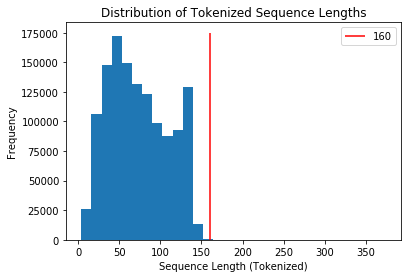

In [10]:
plt.hist(char_translator.seq_sizes, bins=30);
plt.vlines(max_sequence_length, 0, 175000, label='160', color='red');
plt.title('Distribution of Tokenized Sequence Lengths');
plt.xlabel('Sequence Length (Tokenized)');
plt.ylabel('Frequency');
plt.legend();

In [11]:
X_train_encoded = char_translator.transform(X_train, maxlen=max_sequence_length)
X_test_encoded = char_translator.transform(X_test, maxlen=max_sequence_length)

**Sequence Encoding Examples**

Sequences shorter than 160 tokens are zero padded (pre-padding) and sequences longer than 160 are truncated (pre-truncation) to make all sequence lengths 160.

In [12]:
print('Raw:')
print(X_train[4])
print('\n','_______________________','\n')
print('Encoded:')
print(X_train_encoded[4])
print('\n','_______________________','\n')
print('Reverse Transformed:')
print(char_translator.inverse_transform(X_train_encoded[4:5]))

Raw:
upper airways problem 

 _______________________ 

Encoded:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16 22 22  4 11  3
  7  8 11 19  7 17 10  3 22 11  6 24 13  4 15  3]

 _______________________ 

Reverse Transformed:
['<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

## Model

The model implementation is build by `get_convolutional_model`.
This function takes the vocabulary size, the max sequence length, and the number of classes.

### Architecture

The architecture of the model is described in section 2.3 of the [paper](https://arxiv.org/pdf/1509.01626.pdf).

#### Convolutions with Pooling

There are 6 convolutions with 3 pooling operations.

|  Layer  | ConV Layer Name | Large Feature | Small Feature | Kernel | Pool | Pool Layer Name |
|:-------:|:---------------:|:-------------:|:-------------:|:------:|:----:|:---------------:|
| 1             |  conv_1   |   1024        |   256         | 7      |  3   | pooling_1  |
| 2             | conv_2    |   1024        |   256         | 7      |  3   | pooling_2  |
| 3             |  conv_3   |   1024        |   256         | 3      |  N/A | N/A  |
| 4             | conv_4    |   1024        |   256         | 3      |  N/A | N/A  |
| 5             |  conv_5   |   1024        |   256         | 3      |  N/A | N/A  |
| 6             | conv_6    |   1024        |   256         | 3      |  3   | pooling_3  |

#### Dense and Output

|  Layer  | Name | Large Feature | Small Feature |
|:-------:|:---------------:|:-------------:|:-------------:|
| 7       |  dense_out_1   |   2048        |   1024         |
| 8       | dense_out_2    |   2048        |   1024         |
| 9       |  output        |   Number of Classes   |   Number of Classes |

Dropout of probability of 0.5 is included between each fully connected layer.


In [13]:
model = get_convolutional_model(char_translator.vocab_size,
                                max_sequence_length, 
                                2) # 2 is the number of classes

#### Model Summary and Image

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
character_embedding (Embeddi (None, 160, 300)          46800     
_________________________________________________________________
input_dropout (Dropout)      (None, 160, 300)          0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 154, 256)          537856    
_________________________________________________________________
pooling_1 (MaxPooling1D)     (None, 51, 256)           0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 45, 256)           459008    
_________________________________________________________________
pooling_2 (MaxPooling1D)     (None, 15, 256)           0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 13, 256)           1

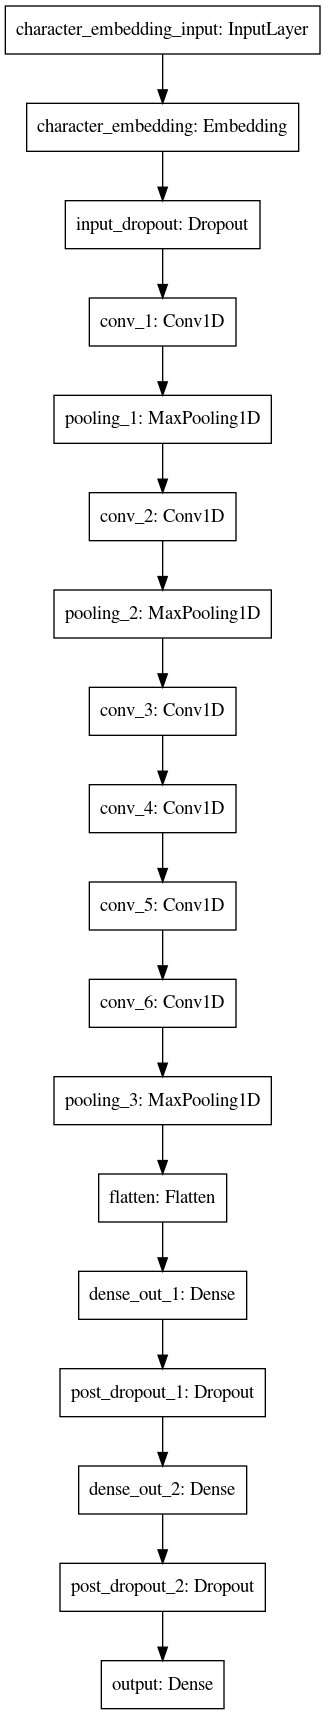

In [16]:
#plot_model(model, to_file='./images/model.png')

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2)

hist = model.fit(X_train_encoded, y_train,
          validation_data=(X_test_encoded, y_test),
          epochs=15, batch_size=1000,
          callbacks=[es])

Epoch 1/15
1280/1280 [==============================] - 321s 251ms/step - loss: 0.4947 - accuracy: 0.7455 - val_loss: 0.4186 - val_accuracy: 0.8079
Epoch 2/15
1280/1280 [==============================] - 313s 245ms/step - loss: 0.4089 - accuracy: 0.8132 - val_loss: 0.4006 - val_accuracy: 0.8172
Epoch 3/15
1280/1280 [==============================] - 308s 241ms/step - loss: 0.3873 - accuracy: 0.8254 - val_loss: 0.3940 - val_accuracy: 0.8218
Epoch 4/15
1280/1280 [==============================] - 308s 241ms/step - loss: 0.3701 - accuracy: 0.8343 - val_loss: 0.3936 - val_accuracy: 0.8220
Epoch 5/15
1280/1280 [==============================] - 307s 240ms/step - loss: 0.3552 - accuracy: 0.8423 - val_loss: 0.4018 - val_accuracy: 0.8204
Epoch 6/15
1280/1280 [==============================] - 307s 240ms/step - loss: 0.3406 - accuracy: 0.8497 - val_loss: 0.3994 - val_accuracy: 0.8208


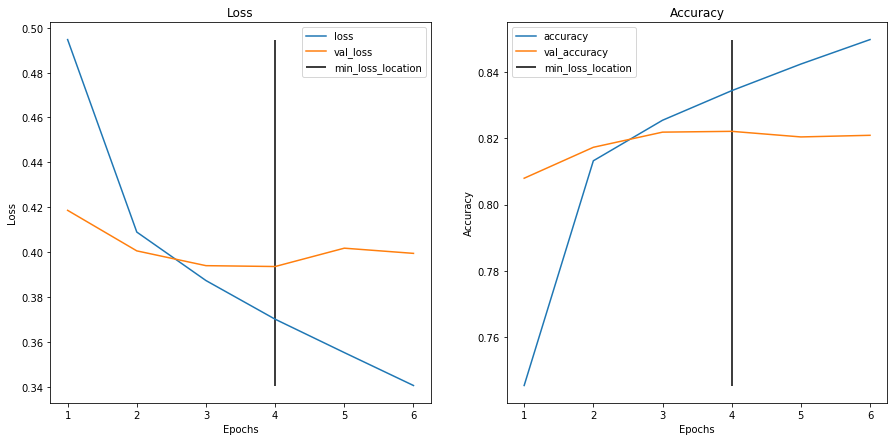

In [16]:
plot_loss_accuracy(hist)

## Comparisons to Other Models

Two other models are used for comparison: a bidirectional LSTM and the [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4).
